In [1]:
import distmesh as dm
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
from scipy.sparse import csr_matrix,lil_matrix
from scipy.sparse import diags


pi = math.pi

In [2]:
# Function for stiffness matrix. Adapted from https://github.com/mar1akc/transition_path_theory_FEM_distmesh/blob/main/FEM_TPT.py
def stima3(verts):
    Aux = np.ones((3,3))
    Aux[1:3,:] = np.transpose(verts)
    rhs = np.zeros((3,2))
    rhs[1,0] = 1
    rhs[2,1] = 1
    G = np.zeros((3,2))
    G[:,0] = np.linalg.solve(Aux,rhs[:,0])
    G[:,1] = np.linalg.solve(Aux,rhs[:,1])
    M = 0.5*np.linalg.det(Aux)*np.matmul(G,np.transpose(G))
    return M

count =  200 displacement =  0.005895625146197294
count =  400 displacement =  0.0036539384827185186
count =  600 displacement =  0.0014228278715262828


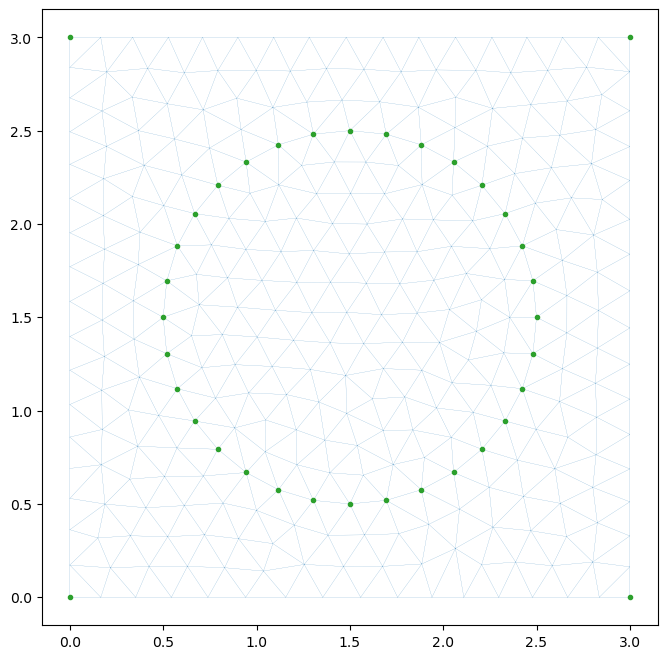

In [3]:
# L-shape
fig, ax = plt.subplots(figsize=(8,8))

# dist func
dBox = lambda p: dm.drectangle(p,0,3,0,3)
# fixed points
h0 = 2*pi/32
n = int(np.round(2*pi/h0))
pfix = [[math.cos(2*pi*i/n)+1.5, math.sin(2*pi*i/n)+1.5] for i in range(n)]
pfix.extend([[0,0],[0,3],[3,0],[3,3]])
# solve system
[pts,tri] = dm.distmesh2D(dBox, dm.huniform, h0, [0, 3, 0, 3], pfix)
Npts,Ntri = len(pts),len(tri)

ax.set_aspect(1)
plt.plot([p[0] for p in pfix], [p[1] for p in pfix],'.')

In [4]:
# FEM also adapted from https://github.com/mar1akc/transition_path_theory_FEM_distmesh/blob/main/FEM_TPT.py
def FEM_current(pts,tri,a,fig=True):
    # useful values
    Npts = len(pts)
    Ntri = len(tri)

    # indices for points on D0, D1, Neuman Boundary
    ID1 = [i for i in range(Npts) if abs(pts[i][0]-3) < h0/4]
    ID0 = [i for i in range(Npts) if abs(pts[i][0]-0) < h0/4]
    IN  = [i for i in range(Npts) if min(abs(pts[i][1]-0),abs(pts[i][1]-3)) < h0/4 and i not in ID0 and i not in ID1]
    # indices for free points
    Ifree = [i for i in range(len(pts)) if i not in ID0 and i not in ID1]


    # initialize matrices
    A = lil_matrix((Npts,Npts), dtype = float)
    b = np.zeros(Npts)
    u = np.zeros(Npts)

    u[ID1] = 1

    for j in range(Ntri):
        v = pts[tri[j,:],:] # vertices of mesh triangle
        vmid = np.reshape(np.sum(v,axis=0)/3,(1,2)) # midpoint of mesh triangle
        ind = tri[j,:]
        indt = np.array(ind)[:,None]
        A[indt,ind] = A[indt,ind] + stima3(v)*a(vmid[0])

    # load vector
    b = b - A@u # remove D1 values...

    u[Ifree] = scipy.sparse.linalg.spsolve(A[np.ix_(Ifree,Ifree)].tocsr(),b[Ifree])

    if fig:
        ax = plt.figure().add_subplot(projection='3d')

        ax.plot_trisurf(pts[:,0], pts[:,1], triangles=tri, Z=u*2, linewidth=0.2,cmap=plt.cm.autumn)
        # A.toarray()

        ax.view_init(20, 140)
    return u

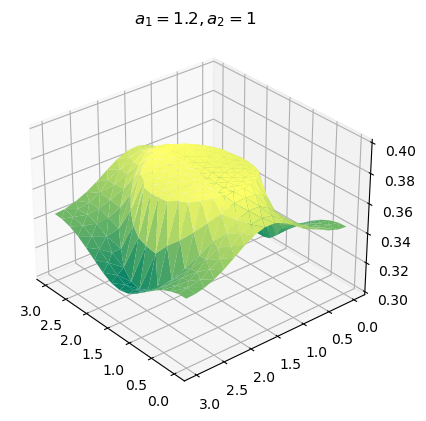

In [5]:
#create a func
def a(p):
    if ((p[0]-1.5)**2 + (p[1]-1.5)**2) < 1: return 1.2 # a1
    else: return 1
    
u = FEM_current(pts,tri,a,False)

CurrentL = [[] for _ in range(Npts)]

#  [y2-y3 y3-y1 y1-y2][u1]
#  [x3-x2 x1-x3 x2-x1][u2] / [x1(y2-y3) + x2(y3-y1) + x3(y1-y2)]
#                     [u3]   
def grad(v,u):
    v  = np.transpose(v)      #[p1,p2,p3] (2x3 mat)
    v2 = np.roll(v,-1,axis=1) #[p2,p3,p1]
    v3 = np.roll(v,-2,axis=1) #[p3,p1,p2]
    # main matrix
    A = np.zeros((2,3), dtype = float)
    A[0,:] = v2[1,:] - v3[1,:]
    A[1,:] = v3[0,:] - v2[0,:]
    # denominator
    D = np.dot(v2[1,:]-v3[1,:],v[0,:])
    # equation above
    return np.matmul(A,u)/D


for j in range(Ntri):
    v = pts[tri[j,:],:] # vertices of mesh triangle
    vmid = np.reshape(np.sum(v,axis=0)/3,(1,2)) # midpoint of mesh triangle
    G = grad(v,u[tri[j,:]]) # gradient
    J = np.linalg.norm(-a(vmid[0])*G) # current (using norm of vector)
    for i in tri[j,:]:
        CurrentL[i].append(J)
        

Current = [np.mean(J_List) for J_List in CurrentL]

ax = plt.figure().add_subplot(projection='3d')

ax.plot_trisurf(pts[:,0], pts[:,1], Current, triangles=tri, linewidth=0.2,cmap=plt.cm.summer)
# A.toarray()

ax.view_init(30, 140)
ax.set_zlim([.3,.4])
ax.set_title(r'$a_1=1.2,a_2=1$')
plt.savefig('a1=1,2.pdf')

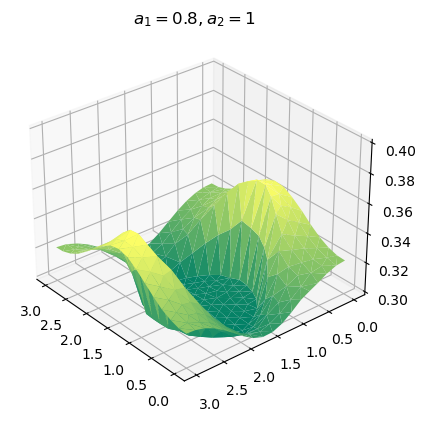

In [6]:
#create a func
def a(p):
    if ((p[0]-1.5)**2 + (p[1]-1.5)**2) < 1: return 0.8 # a1
    else: return 1
    
u = FEM_current(pts,tri,a,False)

CurrentL = [[] for _ in range(Npts)]

#  [y2-y3 y3-y1 y1-y2][u1]
#  [x3-x2 x1-x3 x2-x1][u2] / [x1(y2-y3) + x2(y3-y1) + x3(y1-y2)]
#                     [u3]   
def grad(v,u):
    v  = np.transpose(v)      #[p1,p2,p3] (2x3 mat)
    v2 = np.roll(v,-1,axis=1) #[p2,p3,p1]
    v3 = np.roll(v,-2,axis=1) #[p3,p1,p2]
    # main matrix
    A = np.zeros((2,3), dtype = float)
    A[0,:] = v2[1,:] - v3[1,:]
    A[1,:] = v3[0,:] - v2[0,:]
    # denominator
    D = np.dot(v2[1,:]-v3[1,:],v[0,:])
    # equation above
    return np.matmul(A,u)/D


for j in range(Ntri):
    v = pts[tri[j,:],:] # vertices of mesh triangle
    vmid = np.reshape(np.sum(v,axis=0)/3,(1,2)) # midpoint of mesh triangle
    G = grad(v,u[tri[j,:]]) # gradient
    J = np.linalg.norm(-a(vmid[0])*G) # current (using norm of vector)
    for i in tri[j,:]:
        CurrentL[i].append(J)
        

Current = [np.mean(J_List) for J_List in CurrentL]

ax = plt.figure().add_subplot(projection='3d')

ax.plot_trisurf(pts[:,0], pts[:,1], Current, triangles=tri, linewidth=0.2,cmap=plt.cm.summer)
# A.toarray()

ax.view_init(30, 140)
ax.set_zlim([.3,.4])
ax.set_title(r'$a_1=0.8,a_2=1$')
plt.savefig('a1=0,8.pdf')